# Relax Inc

<b>CASE STUDY</b>

<i>Background</i>
* Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period.
* Identify which factors predict future user adoption.

<i>Results</i>
* Provide a brief writeup of findings (the more concise, the better, no more than one page).
* Show summary tables, graphs, code, or queries that can understand your approach. 
* Note any factors you considered or investigation you did, even if they did not pan out. 
* Identify any further research or data you think would be valuable.


In [1]:
#Python Modules
import pandas as pd
import numpy as np
import datetime as dttm
import itertools as itool

from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

### 1 LOAD, WRANGLE DATA

In [2]:
#Load Data
flpth01 = 'relax_challenge/takehome_users.csv'
flpth02 = 'relax_challenge/takehome_user_engagement.csv'

df_thusers_01 = pd.read_csv(flpth01, na_values = [''])
df_thusereng_01 = pd.read_csv(flpth02)

<b>1.1 TAKEHOME USER ENGAGEMENT - FEATURE ENGINEER</b>

In [3]:
#time_stamp to datetime
df_thusereng_01.loc[:,'time_stamp'] = pd.to_datetime(df_thusereng_01.loc[:,'time_stamp'])

In [4]:
df_thusereng_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [5]:
df_thusereng_01.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
#visited
df_thusereng_01.loc[:,'visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [7]:
#date_visited
df_thusereng_01.loc[:,'date_visited'] = pd.to_datetime(df_thusereng_01.loc[:,'time_stamp'].dt.date)
df_thusereng_01.sort_values(by=['user_id','date_visited'],inplace=True)
df_thusereng_01.head()

,time_stamp,user_id,visited,date_visited
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [8]:
#visits by date
df_vstctbydate_01 = df_thusereng_01.loc[:,['user_id','date_visited','visited']].groupby(['user_id','date_visited']).count()
df_vstctbydate_01.sort_values(by=['user_id','date_visited'],ascending=[True,False],inplace=True)
df_vstctbydate_01.reset_index(inplace=True,drop=False)
df_vstctbydate_01.info()
df_vstctbydate_01.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       207917 non-null  int64         
 1   date_visited  207917 non-null  datetime64[ns]
 2   visited       207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


,user_id,date_visited,visited
0,1,2014-04-22,1
1,2,2014-03-31,1
2,2,2014-03-13,1
3,2,2014-03-09,1
4,2,2014-02-16,1
5,2,2014-02-13,1
6,2,2014-02-09,1
7,2,2014-02-08,1
8,2,2014-02-03,1
9,2,2014-01-08,1


In [9]:
#loop users, check all 7-day windows, if 3 or more records flag 1 else 0
lst_usrid_01 = list(df_vstctbydate_01.loc[:,'user_id'].unique())
wnd_dt_vst_01 = 3

useradopt_dict01 = {}
lst_useradopt_01 = []
for usrid01 in lst_usrid_01:
    is_usrid_01 = df_vstctbydate_01.loc[:,'user_id'] == usrid01
    df_vst_usrid_01 = df_vstctbydate_01.loc[is_usrid_01,['user_id','date_visited']].copy()
    lst_dt_vst_01 = list(set(df_vst_usrid_01.loc[:,'date_visited'].unique()))
    
    adpt_flg01 = 0
    for dt01 in lst_dt_vst_01:
        lst_inwnd01 = [1 for dt02 in lst_dt_vst_01 if np.abs((dt02-dt01).astype('timedelta64[D]').astype(int)) <= wnd_dt_vst_01]
        if sum(lst_inwnd01) >= 3:
            adpt_flg01 = 1
        else:
            adpt_flg01 = 0
        
        if adpt_flg01 == 1:
            break
    
    useradopt_dict01[usrid01] = adpt_flg01
    lst_useradopt_01.append([usrid01,adpt_flg01])
    
    if usrid01 % 100 == 0:
        print(usrid01,len(lst_dt_vst_01),type(lst_dt_vst_01[0]),lst_dt_vst_01[0],adpt_flg01)
    
    #if usrid01 >= 300:
        #break
    

100 1 <class 'numpy.datetime64'> 2013-06-17T00:00:00.000000000 0
200 159 <class 'numpy.datetime64'> 2014-06-04T00:00:00.000000000 1
300 1 <class 'numpy.datetime64'> 2012-11-09T00:00:00.000000000 0
400 1 <class 'numpy.datetime64'> 2013-10-09T00:00:00.000000000 0
500 2 <class 'numpy.datetime64'> 2014-05-24T00:00:00.000000000 0
600 1 <class 'numpy.datetime64'> 2012-10-25T00:00:00.000000000 0
700 1 <class 'numpy.datetime64'> 2014-05-29T00:00:00.000000000 0
900 1 <class 'numpy.datetime64'> 2013-06-27T00:00:00.000000000 0
1100 2 <class 'numpy.datetime64'> 2013-06-16T00:00:00.000000000 0
1200 1 <class 'numpy.datetime64'> 2014-05-03T00:00:00.000000000 0
1400 1 <class 'numpy.datetime64'> 2012-06-06T00:00:00.000000000 0
1500 6 <class 'numpy.datetime64'> 2014-06-03T00:00:00.000000000 0
1600 6 <class 'numpy.datetime64'> 2012-08-20T00:00:00.000000000 0
1700 1 <class 'numpy.datetime64'> 2013-07-29T00:00:00.000000000 0
1900 1 <class 'numpy.datetime64'> 2014-05-08T00:00:00.000000000 0
2000 1 <class 'n

In [10]:
df_useradopt_01 = pd.DataFrame(lst_useradopt_01,columns=['user_id','adopt_flg'])
df_useradopt_01.sort_values(by='user_id',inplace=True)
df_useradopt_01.reset_index(inplace=True,drop=True)
df_useradopt_01.head(20)

,user_id,adopt_flg
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,10,1
8,11,0
9,13,0


In [11]:
useradopt_dict01

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 10: 1,
 11: 0,
 13: 0,
 14: 0,
 17: 0,
 19: 0,
 20: 1,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 33: 0,
 36: 0,
 37: 0,
 41: 0,
 42: 1,
 43: 1,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 53: 1,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 63: 1,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 1,
 72: 0,
 73: 0,
 74: 1,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 80: 1,
 81: 1,
 82: 1,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 1,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 103: 0,
 105: 0,
 106: 0,
 107: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 119: 0,
 121: 0,
 123: 0,
 124: 0,
 125: 0,
 126: 0,
 127: 0,
 128: 0,
 132: 0,
 133: 1,
 135: 1,
 136: 0,
 138: 0,
 139: 0,
 140: 0,
 141: 1,
 142: 0,
 143: 0,
 144: 0,
 146: 1,
 147: 0,
 150: 0,
 151: 0,
 153: 1,
 154: 0,
 155: 0

<b>1.2 TAKEHOME USERS - FEATURE ENGINEER</b>

In [12]:
#creation_time to datetime
df_thusers_01.loc[:,'creation_time'] = pd.to_datetime(df_thusers_01.loc[:,'creation_time'])

In [13]:
df_thusers_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [14]:
df_thusers_01.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
#null values
df_thusers_01.isna().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool

In [16]:
df_thusers_01[df_thusers_01.isna().any(axis=1)]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,1.388117e+09,0,0,69,NaN
11,12,2014-04-17 23:48:38,Mathiesen L�rke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0
...,...,...,...,...,...,...,...,...,...,...
11993,11994,2012-06-05 04:46:16,Grimstone Joel,conxzghp@eaouk.com,GUEST_INVITE,NaN,0,0,84,5450.0
11994,11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,1.382449e+09,0,0,0,NaN
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [17]:
#duplicates on (email)
lst_colkey01 = ['email']
is_dupe01 = df_thusers_01.duplicated(subset=lst_colkey01, keep=False)
df_thusers_01.loc[is_dupe01,:].sort_values(by=['email','creation_time'],ascending=[True,False])

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1603,1604,2014-02-03 04:48:08,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.391662e+09,0,0,0,4128.0
3822,3823,2012-11-22 05:51:29,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.353650e+09,0,0,169,9498.0
9040,9041,2013-01-03 00:53:47,Bach Amanda,AmandaABach@gmail.com,ORG_INVITE,NaN,0,0,377,6208.0
5280,5281,2012-09-29 11:54:08,Bach Amanda,AmandaABach@gmail.com,SIGNUP_GOOGLE_AUTH,1.401883e+09,0,0,146,NaN
5081,5082,2013-06-25 19:31:11,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.372361e+09,0,0,298,NaN
375,376,2012-08-10 22:27:08,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.344638e+09,1,0,104,NaN
1169,1170,2014-04-27 16:48:34,Sankt Janina,JaninaSankt@gmail.com,ORG_INVITE,1.398617e+09,1,1,285,623.0
3605,3606,2013-05-10 08:31:59,Sankt Janina,JaninaSankt@gmail.com,GUEST_INVITE,1.369816e+09,0,0,84,8356.0
10153,10154,2014-05-06 10:57:37,Neudorf Kerstin,KerstinNeudorf@gmail.com,ORG_INVITE,1.400238e+09,0,0,359,4563.0
11244,11245,2014-01-17 18:05:15,Neudorf Kerstin,KerstinNeudorf@gmail.com,SIGNUP,1.389982e+09,1,1,68,NaN


In [18]:
#duplicates, remove if needed
lst_colkey01 = ['email']
is_dupe01 = df_thusers_01.sort_values(by=['email','creation_time'],ascending=[True,True]).duplicated(subset=lst_colkey01, keep='first')
#duplicates to remove (newer creation_time)
df_thusers_01.loc[is_dupe01,:].sort_values(by=['email','creation_time'],ascending=[True,False])

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1603,1604,2014-02-03 04:48:08,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.391662e+09,0,0,0,4128.0
9040,9041,2013-01-03 00:53:47,Bach Amanda,AmandaABach@gmail.com,ORG_INVITE,NaN,0,0,377,6208.0
5081,5082,2013-06-25 19:31:11,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.372361e+09,0,0,298,NaN
1169,1170,2014-04-27 16:48:34,Sankt Janina,JaninaSankt@gmail.com,ORG_INVITE,1.398617e+09,1,1,285,623.0
10153,10154,2014-05-06 10:57:37,Neudorf Kerstin,KerstinNeudorf@gmail.com,ORG_INVITE,1.400238e+09,0,0,359,4563.0
2751,2752,2013-10-12 22:10:03,Mueller Klaus,KlausMueller@gustr.com,ORG_INVITE,1.381616e+09,0,0,31,8202.0
6432,6433,2014-05-09 10:31:42,Kappel Kristin,KristinKappel@yahoo.com,SIGNUP,1.399804e+09,1,1,202,NaN
6536,6537,2014-05-09 00:19:37,Bertelsen L�rke,LaerkeMBertelsen@gmail.com,PERSONAL_PROJECTS,NaN,1,1,127,NaN
3955,3956,2014-02-06 06:45:03,N�rgaard Lasse,LasseLNrgaard@gmail.com,ORG_INVITE,1.401000e+09,0,0,9,6442.0
11905,11906,2014-04-14 21:24:59,Duerr Leonie,LeonieDuerr@gmail.com,ORG_INVITE,1.401917e+09,0,0,200,190.0


In [19]:
#in_scope_flg
df_thusers_01.loc[:,'in_scope_flg'] = 1
df_thusers_01.loc[:,'in_scope_flg'] = (~is_dupe01).astype(int)
df_thusers_01.loc[is_dupe01,:]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,in_scope_flg
1169,1170,2014-04-27 16:48:34,Sankt Janina,JaninaSankt@gmail.com,ORG_INVITE,1.398617e+09,1,1,285,623.0,0
1603,1604,2014-02-03 04:48:08,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.391662e+09,0,0,0,4128.0,0
2751,2752,2013-10-12 22:10:03,Mueller Klaus,KlausMueller@gustr.com,ORG_INVITE,1.381616e+09,0,0,31,8202.0,0
3426,3427,2013-12-01 11:03:15,Walter Maximilian,MaximilianWalter@gmail.com,SIGNUP_GOOGLE_AUTH,1.385896e+09,0,0,2,NaN,0
3955,3956,2014-02-06 06:45:03,N�rgaard Lasse,LasseLNrgaard@gmail.com,ORG_INVITE,1.401000e+09,0,0,9,6442.0,0
4226,4227,2013-12-20 23:08:20,Brandt Thomas,ThomasBrandt@gmail.com,PERSONAL_PROJECTS,NaN,0,0,402,NaN,0
5081,5082,2013-06-25 19:31:11,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.372361e+09,0,0,298,NaN,0
6293,6294,2013-05-31 03:12:35,Schr�der Mandy,MandySchroder@gustr.com,ORG_INVITE,1.370316e+09,0,0,58,4241.0,0
6346,6347,2014-04-14 07:58:54,Winther Magnus,MagnusSWinther@jourrapide.com,SIGNUP,1.397549e+09,0,0,51,NaN,0
6432,6433,2014-05-09 10:31:42,Kappel Kristin,KristinKappel@yahoo.com,SIGNUP,1.399804e+09,1,1,202,NaN,0


In [20]:
#creation_source
df_thusers_01.loc[:,'creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [21]:
#creation_source - encode map
crtn_src_le_01 = LabelEncoder()
crtn_src_lbl_01 = crtn_src_le_01.fit_transform(df_thusers_01.loc[:,'creation_source'])
crtn_src_lblmap_01 = {idx01: lbl01 for idx01, lbl01 in enumerate(crtn_src_le_01.classes_)}
crtn_src_lblmap_01

{0: 'GUEST_INVITE',
 1: 'ORG_INVITE',
 2: 'PERSONAL_PROJECTS',
 3: 'SIGNUP',
 4: 'SIGNUP_GOOGLE_AUTH'}

In [22]:
#creation_source - encode column
df_thusers_01.loc[:,'crtn_src_idx'] = crtn_src_lbl_01
df_thusers_01.loc[:,['creation_source','crtn_src_idx']].head(10)

,creation_source,crtn_src_idx
0,GUEST_INVITE,0
1,ORG_INVITE,1
2,ORG_INVITE,1
3,GUEST_INVITE,0
4,GUEST_INVITE,0
5,GUEST_INVITE,0
6,SIGNUP,3
7,PERSONAL_PROJECTS,2
8,PERSONAL_PROJECTS,2
9,ORG_INVITE,1


In [23]:
#creation_source - one-hot encode column to dataframe
crtn_src_ohe_01 = OneHotEncoder()
crtn_src_lbl_01 = crtn_src_ohe_01.fit_transform(df_thusers_01.loc[:,['crtn_src_idx']]).toarray()
crtn_src_binfeat_01 = pd.DataFrame(crtn_src_lbl_01, columns=list(crtn_src_le_01.classes_))

crtn_src_colrename_01 = {'GUEST_INVITE':'guest_inv_flg','ORG_INVITE':'org_inv_flg','PERSONAL_PROJECTS':'per_proj_flg',
    'SIGNUP':'signup_flg','SIGNUP_GOOGLE_AUTH':'signup_googauth_flg'}
crtn_src_binfeat_01.rename(inplace=True,columns=crtn_src_colrename_01)

crtn_src_binfeat_01.head()

,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [24]:
#creation_source - one-hot encode concat to original dataframe
df_thusers_02 = pd.concat([df_thusers_01,crtn_src_binfeat_01],axis=1)
df_thusers_02.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,in_scope_flg,crtn_src_idx,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,1.0,0.0,0.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,0.0,1.0,0.0,0.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1,1,0.0,1.0,0.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1,0,1.0,0.0,0.0,0.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,0,1.0,0.0,0.0,0.0,0.0


In [25]:
#opted_in_to_mailing_list
df_thusers_01.loc[:,'opted_in_to_mailing_list'].value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

In [26]:
#enabled_for_marketing_drip
df_thusers_01.loc[:,'enabled_for_marketing_drip'].value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

In [27]:
#org_id
df_orgidct_01 = pd.DataFrame(df_thusers_01.loc[:,'org_id'].value_counts())
df_orgidct_01.reset_index(inplace=True)
df_orgidct_01.columns = ['org_id','org_id_ct']
df_orgidct_01.head(10)

,org_id,org_id_ct
0,0,319
1,1,233
2,2,201
3,3,168
4,4,159
5,6,138
6,5,128
7,9,124
8,7,119
9,10,104


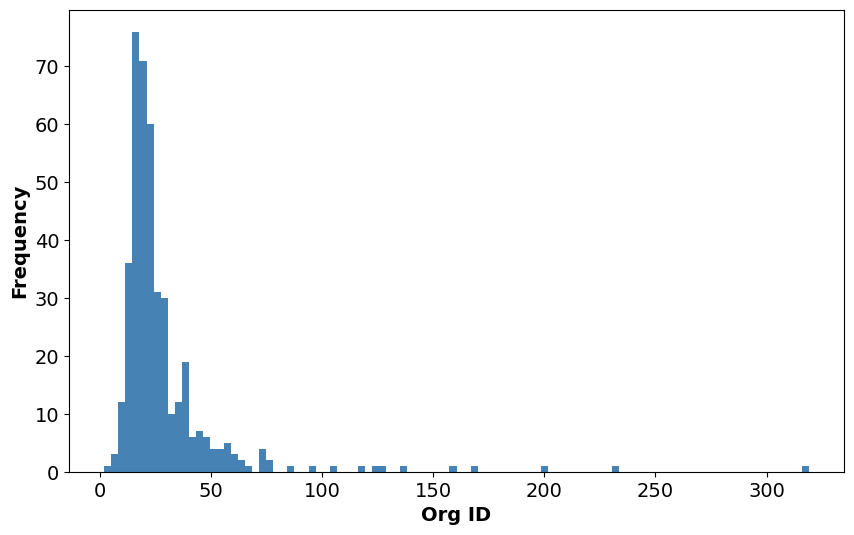

In [28]:
#org_id - histogram of counts
fig01, axes01 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

df_orgidct_01.loc[:,'org_id_ct'].plot(ax=axes01,kind='hist',bins=100,color='steelblue')
axes01.set_xlabel('Org ID', fontsize=14.0, fontweight='bold')
axes01.tick_params(axis='x', labelsize=14)
axes01.set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
axes01.tick_params(axis='y', labelsize=14) 

plt.show()

In [29]:
#org_id - percentiles
df_orgidct_01.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,org_id,org_id_ct
0.1,41.6,14.0
0.2,83.2,16.0
0.3,124.8,17.0
0.4,166.4,19.0
0.5,208.0,22.0
0.6,249.6,24.0
0.7,291.2,28.0
0.8,332.8,34.8
0.9,374.4,47.4


In [30]:
#org_id - bins
bin_orgid_01 = [0,15,35,50,500]
lbl_orgid_01 = [1,2,3,4]
df_orgidbin_01 = pd.cut(df_orgidct_01.loc[:,'org_id_ct'], bins=bin_orgid_01, labels=lbl_orgid_01)
df_orgidbin_01.columns = ['org_id_ct_bin']
pd.DataFrame(df_orgidbin_01).head(10)

,org_id_ct
0,4
1,4
2,4
3,4
4,4
5,4
6,4
7,4
8,4
9,4


In [31]:
df_orgidct_01 = pd.concat([df_orgidct_01,pd.DataFrame(df_orgidbin_01)],axis=1)
df_orgidct_01.head(10)

,org_id,org_id_ct,org_id_ct
0,0,319,4
1,1,233,4
2,2,201,4
3,3,168,4
4,4,159,4
5,6,138,4
6,5,128,4
7,9,124,4
8,7,119,4
9,10,104,4


In [32]:
#org_id - encode map
org_id_lblmap_01 = {rcd01[0] : rcd01[2] for idx01,rcd01 in df_orgidct_01.iterrows()}
org_id_lblmap_01

{0: 4,
 1: 4,
 2: 4,
 3: 4,
 4: 4,
 6: 4,
 5: 4,
 9: 4,
 7: 4,
 10: 4,
 8: 4,
 14: 4,
 11: 4,
 12: 4,
 17: 4,
 18: 4,
 13: 4,
 16: 4,
 20: 4,
 15: 4,
 24: 4,
 25: 4,
 28: 4,
 23: 4,
 30: 4,
 22: 4,
 33: 4,
 40: 4,
 21: 4,
 27: 4,
 31: 4,
 26: 4,
 19: 4,
 32: 4,
 29: 3,
 36: 3,
 53: 3,
 45: 3,
 41: 3,
 50: 3,
 34: 3,
 57: 3,
 39: 3,
 43: 3,
 35: 3,
 49: 3,
 38: 3,
 59: 3,
 37: 3,
 54: 3,
 46: 3,
 47: 3,
 58: 3,
 88: 3,
 66: 3,
 52: 3,
 107: 3,
 61: 3,
 42: 3,
 84: 3,
 98: 3,
 90: 3,
 89: 3,
 64: 3,
 76: 3,
 60: 3,
 62: 3,
 119: 3,
 74: 3,
 69: 3,
 51: 3,
 63: 3,
 75: 3,
 95: 3,
 144: 3,
 44: 3,
 71: 3,
 104: 3,
 70: 2,
 97: 2,
 72: 2,
 68: 2,
 56: 2,
 86: 2,
 109: 2,
 93: 2,
 80: 2,
 48: 2,
 145: 2,
 67: 2,
 94: 2,
 91: 2,
 77: 2,
 163: 2,
 73: 2,
 122: 2,
 106: 2,
 79: 2,
 128: 2,
 55: 2,
 194: 2,
 92: 2,
 201: 2,
 126: 2,
 87: 2,
 240: 2,
 85: 2,
 254: 2,
 275: 2,
 110: 2,
 221: 2,
 102: 2,
 78: 2,
 108: 2,
 178: 2,
 167: 2,
 112: 2,
 192: 2,
 176: 2,
 278: 2,
 208: 2,
 129: 2,
 206: 

In [33]:
df_thusers_02.loc[:,'org_id_idx'] = df_thusers_02.loc[:,'org_id'].map(org_id_lblmap_01)
df_thusers_02.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,in_scope_flg,crtn_src_idx,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg,org_id_idx
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,1.0,0.0,0.0,0.0,0.0,4
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,0.0,1.0,0.0,0.0,0.0,4
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1,1,0.0,1.0,0.0,0.0,0.0,2
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1,0,1.0,0.0,0.0,0.0,0.0,4
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,0,1.0,0.0,0.0,0.0,0.0,2
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1,0,1.0,0.0,0.0,0.0,0.0,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,1,3,0.0,0.0,0.0,1.0,0.0,3
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,1,2,0.0,0.0,1.0,0.0,0.0,3
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,1,2,0.0,0.0,1.0,0.0,0.0,2
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1,1,0.0,1.0,0.0,0.0,0.0,2


In [34]:
#invited_by_user_id
df_thusers_02.loc[:,'invited_by_user_id'].value_counts()

10741.0    13
2527.0     12
11770.0    11
1525.0     11
2308.0     11
           ..
5592.0      1
5289.0      1
3288.0      1
4467.0      1
10872.0     1
Name: invited_by_user_id, Length: 2564, dtype: int64

In [35]:
#create invited_flg
df_thusers_02.loc[:,'invited_flg'] = df_thusers_02.loc[:,'invited_by_user_id'].notna().astype(int)
df_thusers_02.loc[:,'invited_flg'].value_counts()

1    6417
0    5583
Name: invited_flg, dtype: int64

In [36]:
#map adopted users
df_thusers_02.loc[:,'adopt_flg'] = df_thusers_02.loc[:,'object_id'].map(useradopt_dict01)
is_adoptflgna_01 = df_thusers_02.loc[:,'adopt_flg'].isna()
df_thusers_02.loc[is_adoptflgna_01,'adopt_flg'] = 0
df_thusers_02.loc[:,'adopt_flg'].value_counts()

0.0    10485
1.0     1515
Name: adopt_flg, dtype: int64

In [37]:
df_thusers_02.info()
df_thusers_02.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  in_scope_flg                12000 non-null  int64         
 11  crtn_src_idx                12000 non-null  int64     

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,in_scope_flg,crtn_src_idx,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg,org_id_idx,invited_flg,adopt_flg
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,1.0,0.0,0.0,0.0,0.0,4,1,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,0.0,1.0,0.0,0.0,0.0,4,1,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1,1,0.0,1.0,0.0,0.0,0.0,2,1,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1,0,1.0,0.0,0.0,0.0,0.0,4,1,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,0,1.0,0.0,0.0,0.0,0.0,2,1,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1,0,1.0,0.0,0.0,0.0,0.0,1,1,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,1,3,0.0,0.0,0.0,1.0,0.0,3,0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,1,2,0.0,0.0,1.0,0.0,0.0,3,0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,1,2,0.0,0.0,1.0,0.0,0.0,2,0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1,1,0.0,1.0,0.0,0.0,0.0,2,1,1.0


In [38]:
df_thusers_02.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,in_scope_flg,crtn_src_idx,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg,org_id_idx,invited_flg,adopt_flg
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.998333,1.689750,0.180250,0.354500,0.175917,0.173917,0.115417,2.618750,0.534750,0.126250
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.040792,1.270812,0.384412,0.478381,0.380765,0.379054,0.319537,0.965562,0.498812,0.332145
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


### 2 EXPLORE DATA

In [39]:
#data set
yx_set_02 = ['opted_in_to_mailing_list','enabled_for_marketing_drip',
    'guest_inv_flg','org_inv_flg','per_proj_flg','signup_flg','signup_googauth_flg',
    'org_id_idx','invited_flg','adopt_flg']

in_scope_02 = df_thusers_02.loc[:,'in_scope_flg'] == 1
df_yx_usr_02 = df_thusers_02.loc[in_scope_02,yx_set_02].copy()
df_yx_usr_02.head(10)

,opted_in_to_mailing_list,enabled_for_marketing_drip,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg,org_id_idx,invited_flg,adopt_flg
0,1,0,1.0,0.0,0.0,0.0,0.0,4,1,0.0
1,0,0,0.0,1.0,0.0,0.0,0.0,4,1,0.0
2,0,0,0.0,1.0,0.0,0.0,0.0,2,1,0.0
3,0,0,1.0,0.0,0.0,0.0,0.0,4,1,0.0
4,0,0,1.0,0.0,0.0,0.0,0.0,2,1,0.0
5,0,0,1.0,0.0,0.0,0.0,0.0,1,1,0.0
6,0,1,0.0,0.0,0.0,1.0,0.0,3,0,0.0
7,1,1,0.0,0.0,1.0,0.0,0.0,3,0,0.0
8,0,0,0.0,0.0,1.0,0.0,0.0,2,0,0.0
9,1,1,0.0,1.0,0.0,0.0,0.0,2,1,1.0


In [40]:
df_yx_usr_02.isna().any()

opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
guest_inv_flg                 False
org_inv_flg                   False
per_proj_flg                  False
signup_flg                    False
signup_googauth_flg           False
org_id_idx                    False
invited_flg                   False
adopt_flg                     False
dtype: bool

In [41]:
df_yx_usr_02.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,guest_inv_flg,org_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg,org_id_idx,invited_flg,adopt_flg
count,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000
mean,0.249583,0.149332,0.180551,0.354257,0.176043,0.173790,0.115359,2.619032,0.534808,0.126294
std,0.432790,0.356431,0.384662,0.478308,0.380873,0.378944,0.319468,0.965351,0.498808,0.332194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [42]:
#opted_in_to_mailing_list - means
featn_02 = 'opted_in_to_mailing_list'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                              mean count
opted_in_to_mailing_list                
0                         0.125250  8990
1                         0.129431  2990

In [43]:
#enabled_for_marketing_drip - means
featn_02 = 'enabled_for_marketing_drip'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg       
                                mean  count
enabled_for_marketing_drip                 
0                           0.125797  10191
1                           0.129122   1789

In [44]:
#guest_inv_flg - means
featn_02 = 'guest_inv_flg'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                   mean count
guest_inv_flg                
0.0            0.119487  9817
1.0            0.157189  2163

In [45]:
#org_inv_flg - means
featn_02 = 'org_inv_flg'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                 mean count
org_inv_flg                
0.0          0.128749  7736
1.0          0.121819  4244

In [46]:
#per_proj_flg - means
featn_02 = 'per_proj_flg'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                  mean count
per_proj_flg                
0.0           0.137473  9871
1.0           0.073969  2109

In [47]:
#signup_flg - means
featn_02 = 'signup_flg'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                mean count
signup_flg                
0.0         0.124166  9898
1.0         0.136407  2082

In [48]:
#signup_googauth_flg - means
featn_02 = 'signup_googauth_flg'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg       
                         mean  count
signup_googauth_flg                 
0.0                  0.122382  10598
1.0                  0.156295   1382

In [49]:
#org_id_idx - means
featn_02 = 'org_id_idx'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                mean count
org_id_idx                
1           0.163420   924
2           0.143097  5961
3           0.126486  1850
4           0.084746  3245

In [50]:
#invited_flg - means
featn_02 = 'invited_flg'
df_yx_usr_02.loc[:,[featn_02,'adopt_flg']].groupby(featn_02).agg(['mean','count'])

adopt_flg      
                 mean count
invited_flg                
0             0.11771  5573
1             0.13376  6407

### 3 FIT MODEL: LOGISTIC REGRESSION

In [51]:
#data set
yx_set_03 = [
    'guest_inv_flg','per_proj_flg',
    'signup_flg','signup_googauth_flg',
    'org_id_idx','invited_flg',
    'adopt_flg']
x_set_03 = [
    'guest_inv_flg','per_proj_flg',
    'signup_flg','signup_googauth_flg',
    'org_id_idx','invited_flg']

in_scope_03 = df_thusers_02.loc[:,'in_scope_flg'] == 1
df_yx_usr_03 = df_thusers_02.loc[in_scope_03,yx_set_03].copy()
df_yx_usr_03.head(10)

,guest_inv_flg,per_proj_flg,signup_flg,signup_googauth_flg,org_id_idx,invited_flg,adopt_flg
0,1.0,0.0,0.0,0.0,4,1,0.0
1,0.0,0.0,0.0,0.0,4,1,0.0
2,0.0,0.0,0.0,0.0,2,1,0.0
3,1.0,0.0,0.0,0.0,4,1,0.0
4,1.0,0.0,0.0,0.0,2,1,0.0
5,1.0,0.0,0.0,0.0,1,1,0.0
6,0.0,0.0,1.0,0.0,3,0,0.0
7,0.0,1.0,0.0,0.0,3,0,0.0
8,0.0,1.0,0.0,0.0,2,0,0.0
9,0.0,0.0,0.0,0.0,2,1,1.0


In [52]:
#train,test split
df_yx_usr_trn_03, df_yx_usr_tst_03 = train_test_split(df_yx_usr_03, test_size=0.2)

df_x_usr_trn_03 = df_yx_usr_trn_03.loc[:,x_set_03]
df_y_usr_trn_03 = df_yx_usr_trn_03.loc[:,['adopt_flg']]
df_x_usr_tst_03 = df_yx_usr_tst_03.loc[:,x_set_03]
df_y_usr_tst_03 = df_yx_usr_tst_03.loc[:,['adopt_flg']]

In [53]:
#numpy arrays
x_usr_trn_03 = df_x_usr_trn_03.to_numpy()
y_usr_trn_03 = df_y_usr_trn_03.to_numpy()
y_usr_trn_03 = y_usr_trn_03.reshape((y_usr_trn_03.shape[0],))

x_usr_tst_03 = df_x_usr_tst_03.to_numpy()
y_usr_tst_03 = df_y_usr_tst_03.to_numpy()
y_usr_tst_03 = y_usr_tst_03.reshape((y_usr_tst_03.shape[0],))

In [54]:
#cross validation on training
LR_cv_03 = RepeatedKFold(n_splits=4, n_repeats=10, random_state=123)
LR_model_03 = LogisticRegression()
LR_cv_scores_03 = cross_val_score(LR_model_03, x_usr_trn_03, y_usr_trn_03, scoring='accuracy', cv=LR_cv_03)

In [55]:
#cross validation scores - accuracy
print(np.mean(LR_cv_scores_03),np.std(LR_cv_scores_03))

0.8729131886477463 0.007885275643175906


In [56]:
#test - accuracy
LR_model_res_03 = LR_model_03.fit(x_usr_trn_03,y_usr_trn_03)

LR_model_03.score(x_usr_tst_03,y_usr_tst_03)

0.8768781302170284

In [57]:
#coefficients
LR_model_res_03.coef_[0][:]

array([ 0.30326939, -0.51288264,  0.11726819,  0.37284887, -0.26130025,
        0.02192582])

In [58]:
#feature importance - scaled coefficients
LR_model_coef_03 = list(np.std(x_usr_trn_03, 0)*LR_model_res_03.coef_[0][:])
df_featimp_03 = pd.DataFrame(zip(list(df_x_usr_trn_03.columns),LR_model_coef_03),columns=['feat','impt'])
#zip(list(df_x_usr_trn_03.columns),LR_model_coef_03)
df_featimp_03.loc[:,'impt_abs'] = df_featimp_03.loc[:,'impt'].abs()
df_featimp_03.sort_values(by='impt_abs',ascending=False,inplace=True)

df_featimp_03

,feat,impt,impt_abs
4,org_id_idx,-0.253168,0.253168
1,per_proj_flg,-0.196186,0.196186
3,signup_googauth_flg,0.120011,0.120011
0,guest_inv_flg,0.116377,0.116377
2,signup_flg,0.044303,0.044303
5,invited_flg,0.010940,0.010940


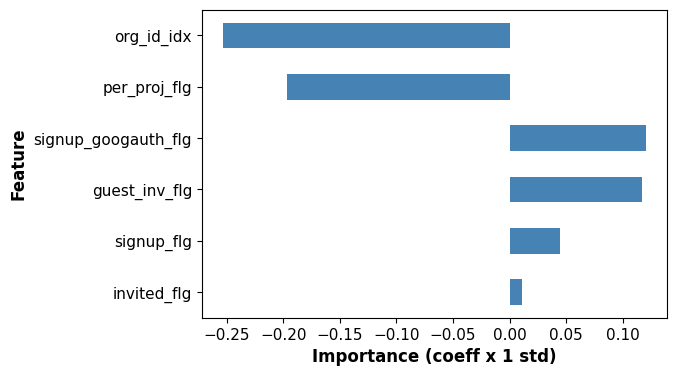

In [59]:
#feature importance - plot
df_featimp_03.sort_values(by='impt_abs',ascending=True,inplace=True)

fig02, axes02 = plt.subplots(nrows=1,ncols=1,figsize=(6,4))

df_featimp_03.plot.barh(ax=axes02,x='feat',y='impt',rot=0,color='steelblue')

axes02.set_xlabel('Importance (coeff x 1 std)', fontsize=12.0, fontweight='bold')
axes02.tick_params(axis='x', labelsize=11)
axes02.set_ylabel('Feature', fontsize=12.0, fontweight='bold') 
axes02.tick_params(axis='y', labelsize=11) 
axes02.get_legend().remove()

plt.show()